<h1 style="font-size:3rem; color: sienna;">Data Wrangling_Join, Combine, and Reshape::</h1>

## Part 2: Combining and Merging Datasets

Data contained in pandas objects can be combined together in a number of ways:

- `pandas.merge` connects rows in DataFrames based on one or more keys. This will be familiar to users of SQL or other relational databases, as it implements database *join* operations.


- `pandas.concat` concatenates or “stacks” together objects along an axis.


- The `combine_first` instance method enables splicing together overlapping data to fill in missing values in one object with values from another.


# Table of Contents

- 2.1  **[Database-Style DataFrame Joins](#Database-Style_DataFrame_Joins)**
   
- 2.2  **[Merging on Index](#Merging_on_Index)**

- 2.3  **[Concatenating Along an Axis](#Concatenating_Along_an_Axis)**

- 2.4  **[Combining Data with Overlap](#Combining_Data_with_Overlap)**

In [1]:
import pandas as pd
import numpy as np

<a id="Database-Style_DataFrame_Joins"></a>
## 2.1 Database-Style DataFrame Joins

*Merge* or *join* operations combine datasets by linking rows using one or more *keys*. These operations are central to relational databases (e.g., SQL-based). The `merge` function in pandas is the main entry point for using these algorithms on your data.
Let’s start with a simple example:

In [2]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)})

In [3]:
df2 = pd.DataFrame({'key': ['a', 'b', 'd'],
                   'data2': range(3)})

In [4]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [5]:
df2

,key,data2
0,a,0
1,b,1
2,d,2


This is an example of a *many-to-one* join; the data in `df1` has multiple rows labeled a and b, whereas `df2` has only one row for each value in the key column. Calling `merge` with these objects we obtain:

In [6]:
pd.merge(df1, df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,a,2,0
3,a,4,0
4,a,5,0
5,b,6,1


Note that I didn’t specify which column to join on. If that information is not specified, `merge` uses the overlapping column names as the keys. It’s a good practice to specify explicitly, though:

In [7]:
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,a,2,0
3,a,4,0
4,a,5,0
5,b,6,1


If the column names are different in each object, you can specify them separately:

In [8]:
df3 = pd.DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                   'data1': range(7)})
df3

,lkey,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [9]:
df4 = pd.DataFrame({'rkey': ['a', 'b', 'd'],
                   'data2': range(3)})
df4

,rkey,data2
0,a,0
1,b,1
2,d,2


In [13]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,a,2,a,0
3,a,4,a,0
4,a,5,a,0
5,b,6,b,1


You may notice that the 'c' and 'd' values and associated data are missing from the result. By default `merge` does an 'inner' join; the keys in the result are the intersection, or the common set found in both tables. Other possible options are `'left'`, `'right'`, and `'outer'`. The outer join takes the union of the keys, combining the effect of applying both left and right joins:

In [14]:
pd.merge(df1, df2, how='outer')

,key,data1,data2
0,a,2.0,0.0
1,a,4.0,0.0
2,a,5.0,0.0
3,b,0.0,1.0
4,b,1.0,1.0
5,b,6.0,1.0
6,c,3.0,NaN
7,d,NaN,2.0


In [15]:
pd.merge(df1, df2, how='right')

,key,data1,data2
0,a,2.0,0
1,a,4.0,0
2,a,5.0,0
3,b,0.0,1
4,b,1.0,1
5,b,6.0,1
6,d,NaN,2


In [16]:
pd.merge(df1, df2, how='left')

,key,data1,data2
0,b,0,1.0
1,b,1,1.0
2,a,2,0.0
3,c,3,NaN
4,a,4,0.0
5,a,5,0.0
6,b,6,1.0


See Table 8-1 for a summary of the options forhow. 

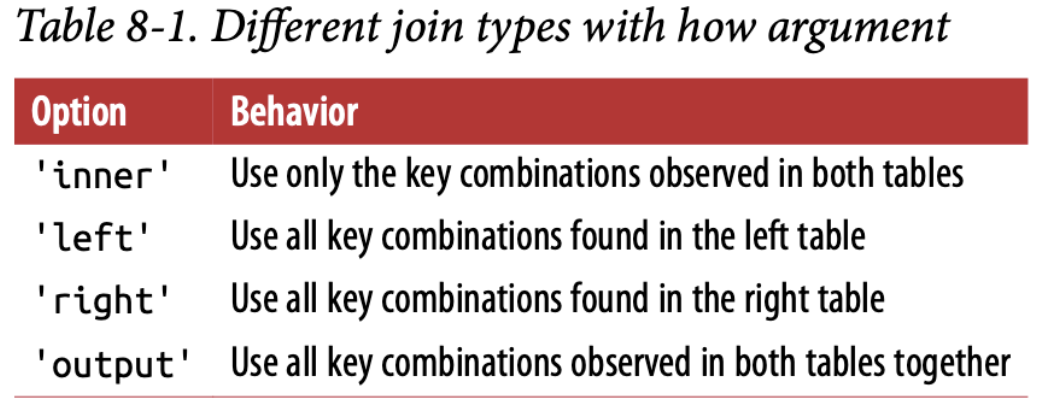

#<img src="Pictures/chapter8/1.png" alt="testtest" style="width: 550px;">

*Many-to-many* merges have well-defined, though not necessarily intuitive, behavior. Here’s an example:

In [17]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                    'data1': range(6)})

In [18]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [19]:
df2 = pd.DataFrame({'key': ['a', 'b', 'a', 'b', 'd'],
                   'data2': range(5)})

In [20]:
df2

,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [21]:
pd.merge(df1, df2, on='key', how='left')

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


*Many-to-many* joins form the Cartesian product of the rows. Since there were three 'b' rows in the left DataFrame and two in the right one, there are six 'b' rows in the result. The join method only affects the distinct key values appearing in the result:

In [22]:
pd.merge(df1, df2, how='inner')

,key,data1,data2
0,b,0,1
1,b,0,3
2,b,1,1
3,b,1,3
4,a,2,0
5,a,2,2
6,a,4,0
7,a,4,2
8,b,5,1
9,b,5,3


To merge with multiple keys, pass a list of column names:

In [23]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'],
                     'key2': ['one', 'two', 'one'],
                     'lval': [1, 2, 3]})

In [24]:
left

,key1,key2,lval
0,foo,one,1
1,foo,two,2
2,bar,one,3


In [25]:
right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                      'key2': ['one', 'one', 'one', 'two'],
                      'rval': [4, 5, 6, 7]})

In [26]:
right

,key1,key2,rval
0,foo,one,4
1,foo,one,5
2,bar,one,6
3,bar,two,7


In [27]:
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,bar,one,3.0,6.0
1,bar,two,NaN,7.0
2,foo,one,1.0,4.0
3,foo,one,1.0,5.0
4,foo,two,2.0,NaN


A last issue to consider in merge operations is the treatment of overlapping column names. While you can address the overlap manually (see the earlier section on renaming axis labels), `merge` has a `suffixes` option for specifying strings to append to overlapping names in the left and right DataFrame objects:

In [28]:
pd.merge(left, right, on='key1') 

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [29]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right')) 

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7



See Table 8-2 for an argument reference on `merge`. Joining using the DataFrame’s row index is the subject of the next section.

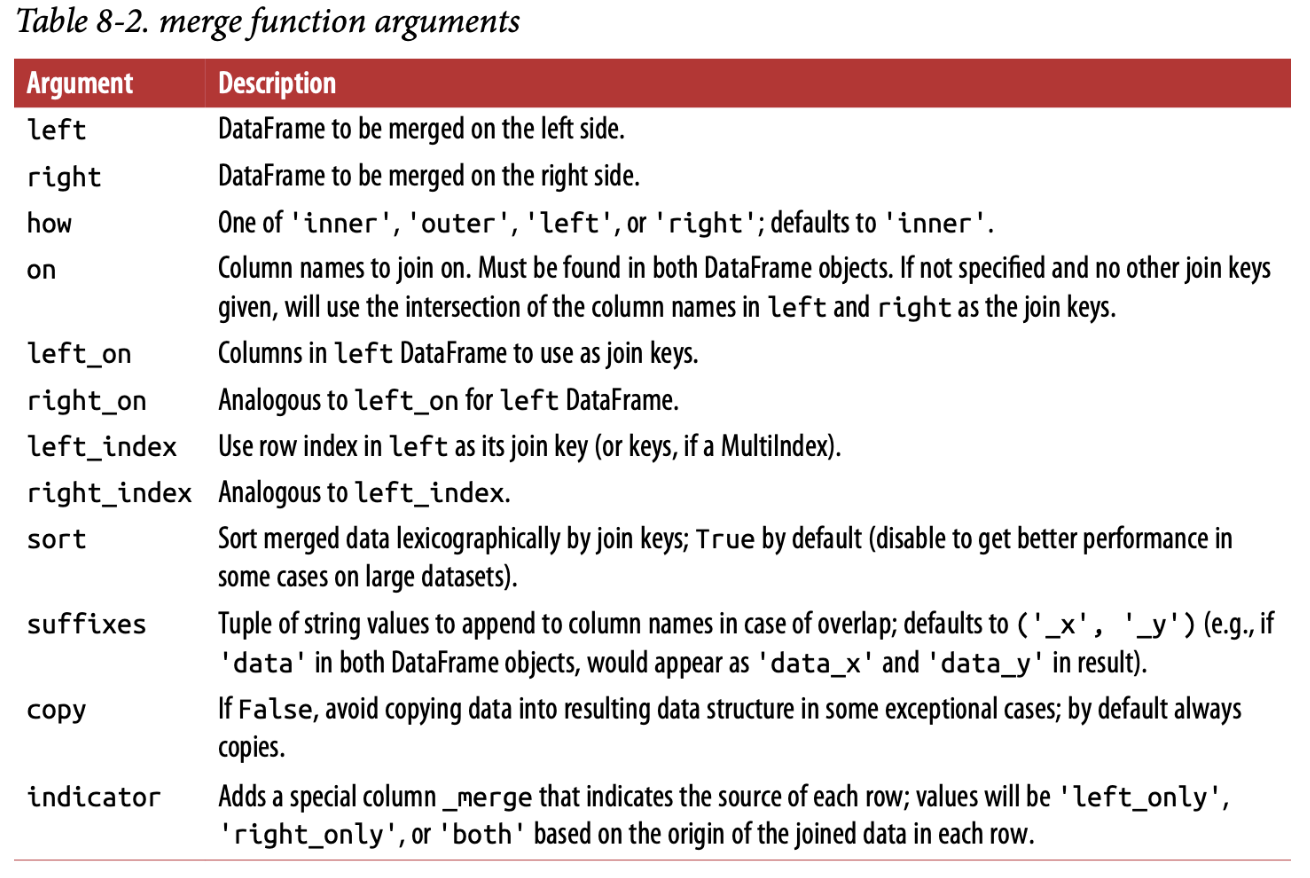

#<img src="Pictures/chapter8/2.png" alt="testtest" style="width: 650px;">

<a id="Merging_on_Index"></a>
## 2.2 Merging on Index

In some cases, the merge key(s) in a DataFrame will be found in its index. In this case, you can pass `left_index=True` or `right_index=True` (or both) to indicate that the index should be used as the merge key:

In [30]:
left1 = pd.DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
                     'value': range(6)})

In [31]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [32]:
right1 = pd.DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])

In [33]:
right1

,group_val
a,3.5
b,7.0


In [34]:
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0


Since the default merge method is to intersect the join keys, you can instead form the union of them with an outer join:

In [36]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


With hierarchically indexed data, things are more complicated, as joining on index is implicitly a multiple-key merge:

In [37]:
lefth = pd.DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio',
                              'Nevada', 'Nevada'],
                              'key2': [2000, 2001, 2002, 2001, 2002],
                              'data': np.arange(5.)})

In [38]:
righth = pd.DataFrame(np.arange(12).reshape((6, 2)),
                     index=[['Nevada', 'Nevada', 'Ohio', 'Ohio',
                              'Ohio', 'Ohio'],
                             [2001, 2000, 2000, 2000, 2001, 2002]],
                     columns=['event1', 'event2'])

In [39]:
lefth

,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [40]:
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

In this case, you have to indicate multiple columns to merge on as a list (note the handling of duplicate index values with `how='outer'`):

In [41]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4,5
0,Ohio,2000,0.0,6,7
1,Ohio,2001,1.0,8,9
2,Ohio,2002,2.0,10,11
3,Nevada,2001,3.0,0,1


In [42]:
pd.merge(lefth, righth, left_on=['key1', 'key2'],
         right_index=True, how='outer')

,key1,key2,data,event1,event2
4,Nevada,2000,NaN,2.0,3.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0


Using the indexes of both sides of the merge is also possible:

In [43]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]],
                     index=['a', 'c', 'e'],
                     columns=['Ohio', 'Nevada'])

In [44]:
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
                     index=['b', 'c', 'd', 'e'],
                      columns=['Missouri', 'Alabama'])

In [45]:
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [46]:
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [47]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


DataFrame has a convenient `join` instance for merging by index. It can also be used to combine together many DataFrame objects having the same or similar indexes but non-overlapping columns. In the prior example, we could have written:

In [48]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In part for legacy reasons (i.e., much earlier versions of pandas), DataFrame’s `join` method performs a left join on the join keys, exactly preserving the left frame’s row index. It also supports joining the index of the passed DataFrame on one of the columns of the calling DataFrame:1m

In [49]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


Lastly, for simple index-on-index merges, you can pass a list of DataFrames to `join` as an alternative to using the more general `concat` function described in the next section:

In [50]:
another = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
                       index=['a', 'c', 'e', 'f'],
                       columns=['New York', 'Oregon'])

In [51]:
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [52]:
left2.join([right2, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


In [53]:
left2.join([right2, another], how='outer')

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0
b,NaN,NaN,7.0,8.0,NaN,NaN
d,NaN,NaN,11.0,12.0,NaN,NaN
f,NaN,NaN,NaN,NaN,16.0,17.0


<a id="Concatenating_Along_an_Axis"></a>
## 2.3 Concatenating Along an Axis

Another kind of data combination operation is referred to interchangeably as concatenation, binding, or stacking. NumPy’s `concatenate` function can do this with NumPy arrays:

In [54]:
arr = np.arange(12).reshape((3, 4))

In [55]:
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [56]:
np.concatenate([arr, arr], axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

In the context of pandas objects such as Series and DataFrame, having labeled axes enable you to further generalize array concatenation. In particular, you have a number of additional things to think about:

- If the objects are indexed differently on the other axes, should we combine the distinct elements in these axes or use only the shared values (the intersection)?

- Do the concatenated chunks of data need to be identifiable in the resulting object?

- Does the “concatenation axis” contain data that needs to be preserved? In many cases, the default integer labels in a DataFrame are best discarded during concatenation.

The `concat` function in pandas provides a consistent way to address each of these concerns. I’ll give a number of examples to illustrate how it works. Suppose we have three Series with no index overlap:

In [62]:
s1 = pd.Series([0, 1], index=['a', 'b'])
s1

a    0
b    1
dtype: int64

In [63]:
s2 = pd.Series([2, 3, 4], index=['c', 'a', 'e'])
s2

c    2
a    3
e    4
dtype: int64

In [64]:
s3 = pd.Series([5, 6], index=['f', 'g'])
s3

f    5
g    6
dtype: int64

Calling `concat` with these objects in a list glues together the values and indexes:

In [65]:
pd.concat([s1, s2, s3])

a    0
b    1
c    2
a    3
e    4
f    5
g    6
dtype: int64

By default `concat` works along axis=0, producing another Series. If you pass `axis=1`, the result will instead be a DataFrame (`axis=1` is the columns):

In [66]:
pd.concat([s1, s2, s3], axis=1)

,0,1,2
a,0.0,3.0,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0



By default concat works along `axis=0`, producing another Series. If you pass `axis=1`, the result will instead be a DataFrame (`axis=1` is the columns):

In [67]:
pd.concat([s1, s2, s3], axis=1)

,0,1,2
a,0.0,3.0,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In this case there is no overlap on the other axis, which as you can see is the sorted union (the `'outer'` join) of the indexes. You can instead intersect them by passing `join='inner'`:

In [68]:
s4 = pd.concat([s1, s3])

In [69]:
s4

a    0
b    1
f    5
g    6
dtype: int64

In [70]:
pd.concat([s1, s4], axis=1)

,0,1
a,0.0,0
b,1.0,1
f,NaN,5
g,NaN,6


In [71]:
pd.concat([s1, s4], axis=1, join='inner')

# In this last example, the 'f' and 'g' labels disappeared because of the join='inner' option.

,0,1
a,0,0
b,1,1


A potential issue is that the concatenated pieces are not identifiable in the result. Suppose instead you wanted to create a hierarchical index on the concatenation axis. To do this, use the `keys` argument:

In [72]:
result = pd.concat([s1, s1, s3], keys=['one', 'two', 'three'])

In [73]:
result

one    a    0
       b    1
two    a    0
       b    1
three  f    5
       g    6
dtype: int64

In [67]:
result.unstack()

,a,b,f,g
one,0.0,1.0,NaN,NaN
two,0.0,1.0,NaN,NaN
three,NaN,NaN,5.0,6.0


In the case of combining Series along `axis=1`, the keys become the DataFrame column headers:

In [74]:
pd.concat([s1, s2, s3], axis=1, keys=['one', 'two', 'three'])

,one,two,three
a,0.0,3.0,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


The same logic extends to DataFrame objects:

In [75]:
df1 = pd.DataFrame(np.arange(6).reshape(3, 2), index=['a', 'b', 'c'],
                   columns=['one', 'two'])

In [76]:
df2 = pd.DataFrame(5 + np.arange(4).reshape(2, 2), index=['a', 'c'],
                  columns=['three', 'four'])

In [77]:
df1

,one,two
a,0,1
b,2,3
c,4,5


In [78]:
df2

,three,four
a,5,6
c,7,8


In [79]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

If you pass a dict of objects instead of a list, the dict’s keys will be used for the `keys` option:

In [80]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

There are additional arguments governing how the hierarchical index is created (see Table 8-3). For example, we can name the created axis levels with the `names` argument:

In [83]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'],
        #   names=['upper', 'lower'])
            names=[,'upper'])

SyntaxError: invalid syntax (154372953.py, line 3)

A last consideration concerns DataFrames in which the row index does not contain any relevant data:

In [84]:
df1 = pd.DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])

#

#

In [85]:
df2 = pd.DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])


In [86]:
df1

,a,b,c,d
0,-1.747940,0.156971,-0.746121,-1.589680
1,3.372492,-0.686881,-1.128946,-0.929480
2,0.199210,-1.335288,2.199708,1.838417


In [87]:
df2

,b,d,a
0,0.077205,0.941852,0.370742
1,2.070030,-0.627363,1.511876



In this case, you can pass `ignore_index=True`:

In [88]:
pd.concat([df1, df2], ignore_index=True)

,a,b,c,d
0,-1.747940,0.156971,-0.746121,-1.589680
1,3.372492,-0.686881,-1.128946,-0.929480
2,0.199210,-1.335288,2.199708,1.838417
3,0.370742,0.077205,NaN,0.941852
4,1.511876,2.070030,NaN,-0.627363


#<img src="Pictures/chapter8/3.png" alt="testtest" style="width: 650px;">

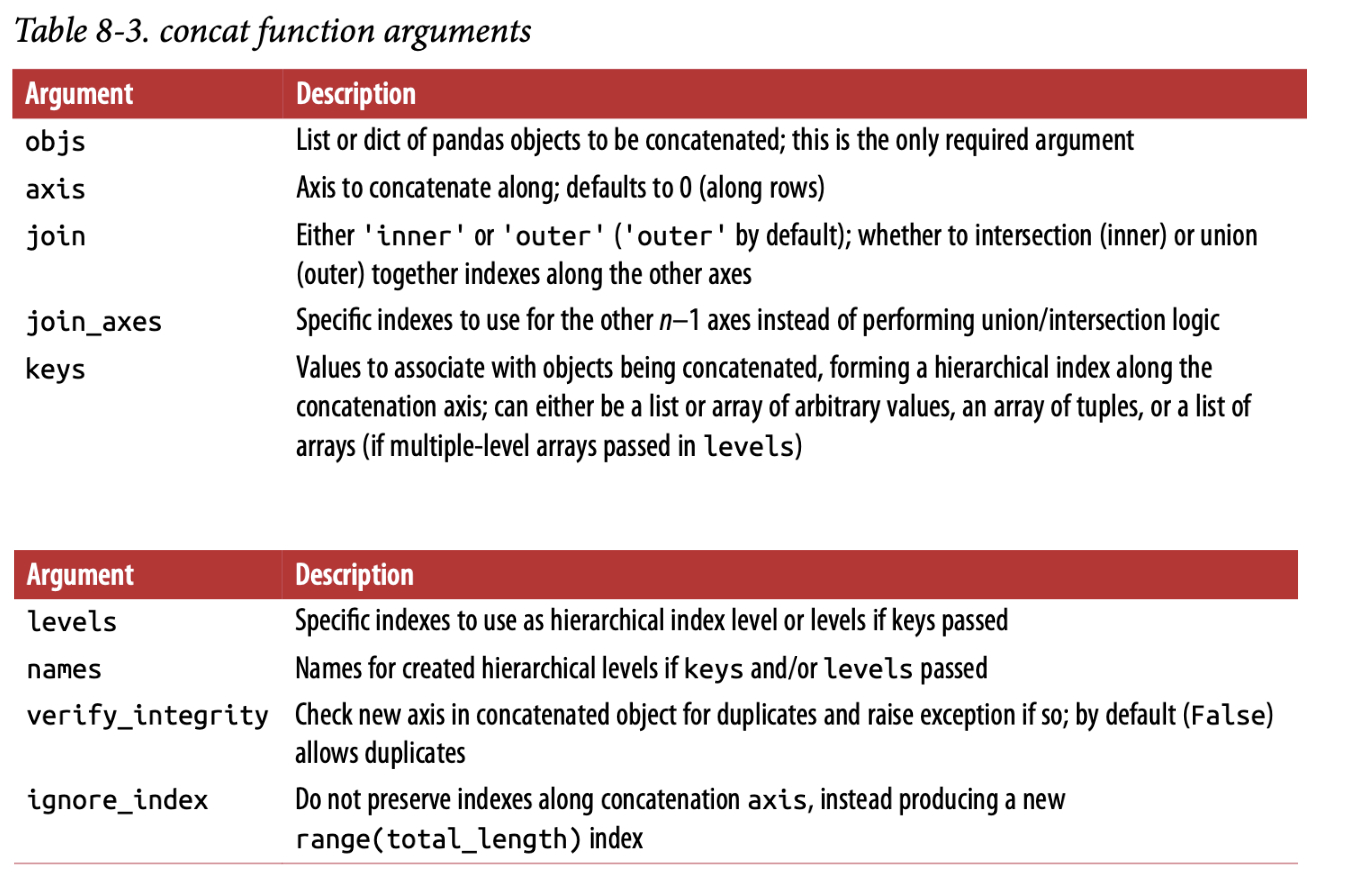

#<img src="Pictures/chapter8/4.png" alt="testtest" style="width: 650px;">

<a id="Combining_Data_with_Overlap"></a>
## 2.4 Combining Data with Overlap

There is another data combination situation that can’t be expressed as either a merge or concatenation operation. You may have two datasets whose indexes overlap in full or part. As a motivating example, consider NumPy’s `where` function, which performs the array-oriented equivalent of an if-else expression:

In [89]:
a = pd.Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
             index=['f', 'e', 'd', 'c', 'b', 'a'])

In [90]:
b = pd.Series(np.arange(len(a), dtype=np.float64),
              index=['f', 'e', 'd', 'c', 'b', 'a'])

In [91]:
b[-1] = np.nan

/var/folders/t6/jzgwrdks2vq53w20jlljrk840000gn/T/ipykernel_53207/1621735104.py:1: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  b[-1] = np.nan


In [92]:
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [93]:
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

In [94]:
np.where(pd.isnull(a), b, a)

array([0. , 2.5, 2. , 3.5, 4.5, nan])

Series has a `combine_first` method, which performs the equivalent of this operation along with pandas’s usual data alignment logic:

In [95]:
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

With DataFrames, `combine_first` does the same thing column by column, so you can think of it as “patching” missing data in the calling object with data from the object you pass:

In [96]:
df1 = pd.DataFrame({'a': [1., np.nan, 5., np.nan],
                    'b': [np.nan, 2., np.nan, 6.],
                    'c': range(2, 18, 4)})

In [97]:
df2 = pd.DataFrame({'a': [5., 4., np.nan, 3., 7.],
                   'b': [np.nan, 3., 4., 6., 8.]})

In [98]:
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [99]:
 df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [92]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN
